SHIELDMAIL — NAIVE BAYES SPAM DETECTION
Loading datasets...
Training data shape: (8572, 2)
Testing  data shape: (2143, 2)
Missing (train): 0 | Missing (test): 0

Class distribution (train):
label
0    6958
1    1614
Name: count, dtype: int64
Spam ratio (train): 0.188

Preprocessing data...
Feature matrix — Train: (8572, 10000), Test: (2143, 10000)

Training Naive Bayes models...

Training MultinomialNB...
MultinomialNB — Acc: 0.9631  Prec: 0.9552  Rec: 0.8441  F1: 0.8962

Training BernoulliNB...
BernoulliNB — Acc: 0.9403  Prec: 0.9182  Rec: 0.7500  F1: 0.8256

Training GaussianNB...
GaussianNB — Acc: 0.7457  Prec: 0.4156  Rec: 0.8589  F1: 0.5601

Best model: MultinomialNB (F1=0.8962)

Hyperparameter tuning for MultinomialNB...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'classifier__alpha': 0.1, 'classifier__fit_prior': True}
Best CV F1: 0.9277

Evaluating MultinomialNB...

Final Performance
Accuracy:  0.9650
Precision: 0.9123
Recall:    0.9010
F1 Score:  

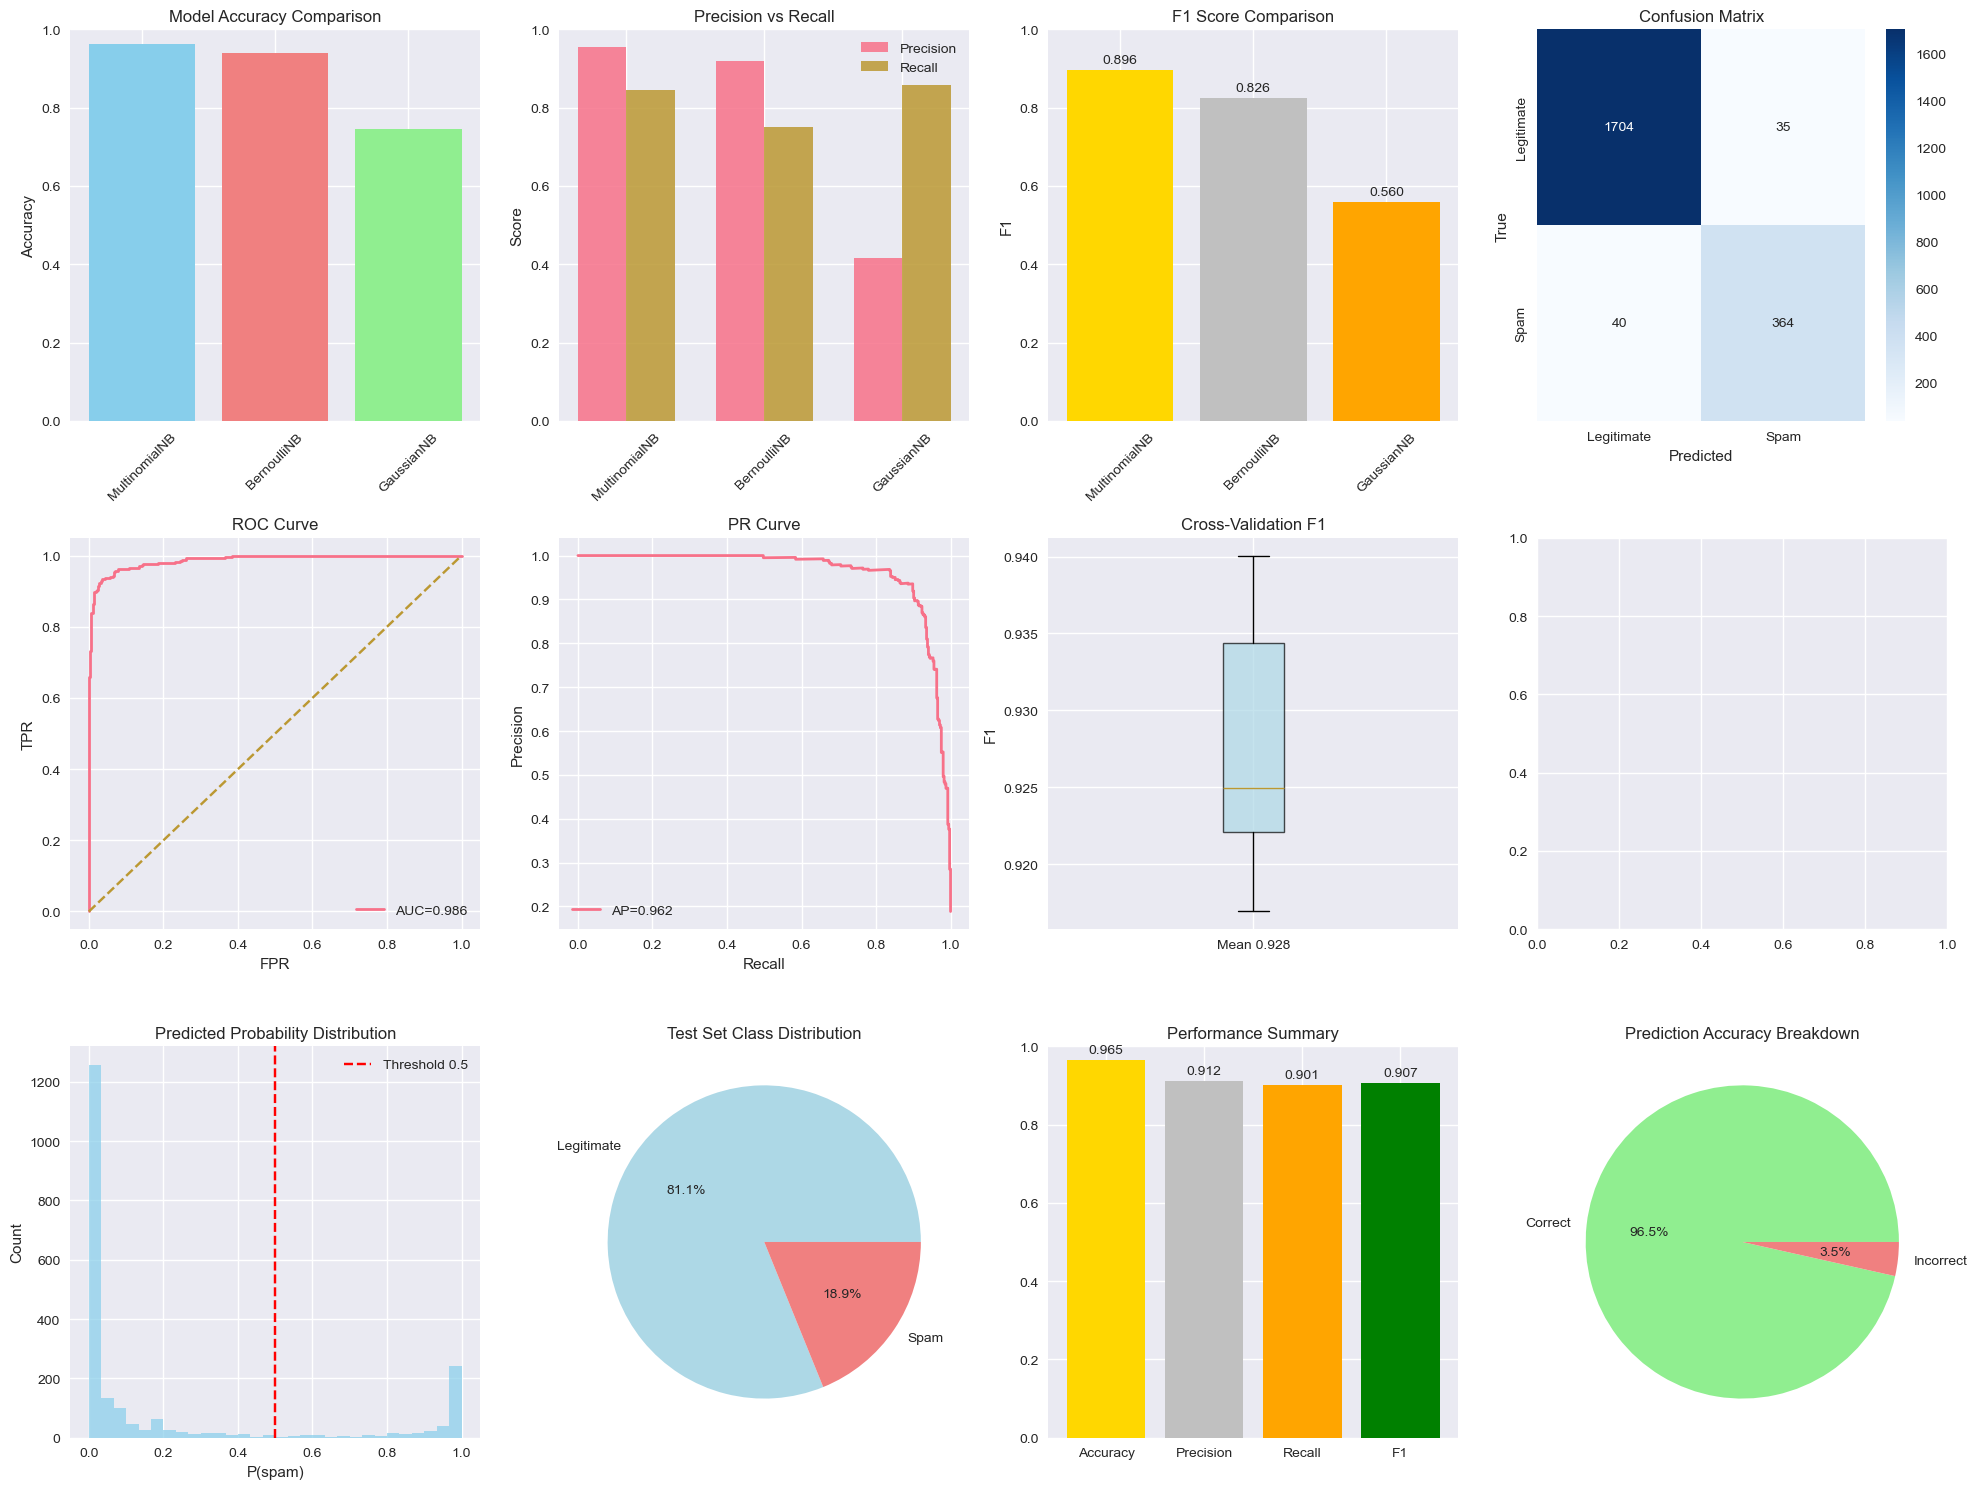

Visualizations saved to /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/model_select/naive_bayes_evaluation.png

Saving results...
Results saved to /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/model_select/

Pipeline completed.


In [1]:
# save as: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/data_processing/naive_bayes_fixed.py
"""
Naive Bayes Classification for Spam Detection
=============================================

Implements a Naive Bayes classifier for spam detection using the processed email datasets.
Includes comprehensive evaluation metrics and visualizations.

Author: ShieldMail Project
Date: 2024
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline

# ---------- Styling ----------
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ---------- Universal path setup (robust to Jupyter/.py) ----------
try:
    THIS_DIR = Path(__file__).parent
except NameError:
    THIS_DIR = Path.cwd()

def find_assignment_root(start: Path) -> Path:
    # Walk up until we hit a folder literally named "Assignment_2"
    for p in [start] + list(start.parents):
        if p.name == "Assignment_2":
            return p
    # Fallback: assume parent of data_processing
    return start.parent

ASSIGNMENT_ROOT  = find_assignment_root(THIS_DIR)          # .../cos30049_spam_detection/Assignment_2
PROCESSED_DIR    = ASSIGNMENT_ROOT / "outputs" / "processed"
MODEL_SELECT_DIR = ASSIGNMENT_ROOT / "outputs" / "model_select"
MODEL_SELECT_DIR.mkdir(parents=True, exist_ok=True)


class SpamDetectionNaiveBayes:
    """
    A comprehensive Naive Bayes implementation for spam detection
    """
    def __init__(self):
        self.models = {
            'MultinomialNB': MultinomialNB(),
            'BernoulliNB': BernoulliNB(),
            'GaussianNB': GaussianNB()
        }
        self.best_model = None
        self.best_model_name = None
        self.vectorizer = None
        self.results = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, train_path: Path, test_path: Path):
        """Load and report on the training and testing datasets."""
        print("Loading datasets...")
        self.train_data = pd.read_csv(train_path)
        self.test_data  = pd.read_csv(test_path)
        print(f"Training data shape: {self.train_data.shape}")
        print(f"Testing  data shape: {self.test_data.shape}")
        print(f"Missing (train): {self.train_data.isnull().sum().sum()} | Missing (test): {self.test_data.isnull().sum().sum()}")
        print("\nClass distribution (train):")
        print(self.train_data['label'].value_counts())
        print(f"Spam ratio (train): {self.train_data['label'].mean():.3f}")
        return self.train_data, self.test_data

    def preprocess_data(self):
        """Vectorize text with TF-IDF; keep digits; unigrams+bigrams."""
        print("\nPreprocessing data...")
        all_text = pd.concat([self.train_data['text'], self.test_data['text']], ignore_index=True)

        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        all_features = self.vectorizer.fit_transform(all_text)

        n_train = len(self.train_data)
        self.X_train = all_features[:n_train]
        self.X_test  = all_features[n_train:]
        self.y_train = self.train_data['label'].astype(int).values
        self.y_test  = self.test_data['label'].astype(int).values

        print(f"Feature matrix — Train: {self.X_train.shape}, Test: {self.X_test.shape}")

    def train_models(self):
        """Train NB variants and collect metrics."""
        print("\nTraining Naive Bayes models...")
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            if name == 'GaussianNB':
                Xtr = self.X_train.toarray()
                Xte = self.X_test.toarray()
                model.fit(Xtr, self.y_train)
                y_pred  = model.predict(Xte)
                y_proba = model.predict_proba(Xte)[:, 1]
            else:
                model.fit(self.X_train, self.y_train)
                y_pred  = model.predict(self.X_test)
                y_proba = model.predict_proba(self.X_test)[:, 1]

            acc = accuracy_score(self.y_test, y_pred)
            pre = precision_score(self.y_test, y_pred, zero_division=0)
            rec = recall_score(self.y_test, y_pred, zero_division=0)
            f1  = f1_score(self.y_test, y_pred, zero_division=0)

            self.results[name] = {
                'model': model,
                'accuracy': acc,
                'precision': pre,
                'recall': rec,
                'f1': f1,
                'predictions': y_pred,
                'probabilities': y_proba
            }
            print(f"{name} — Acc: {acc:.4f}  Prec: {pre:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}")

        self.best_model_name = max(self.results.keys(), key=lambda k: self.results[k]['f1'])
        self.best_model = self.results[self.best_model_name]['model']
        print(f"\nBest model: {self.best_model_name} (F1={self.results[self.best_model_name]['f1']:.4f})")
        return self.results

    def hyperparameter_tuning(self):
        """Grid-search the best NB variant with a vectorizer in a pipeline."""
        print(f"\nHyperparameter tuning for {self.best_model_name}...")
        if self.best_model_name == 'MultinomialNB':
            param_grid = {
                'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
                'classifier__fit_prior': [True, False]
            }
        elif self.best_model_name == 'BernoulliNB':
            param_grid = {
                'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
                'classifier__binarize': [0.0, 0.5, 1.0]
            }
        else:
            print("Skipping tuning for GaussianNB.")
            return None

        pipe = Pipeline([
            ('vectorizer', self.vectorizer),
            ('classifier', self.best_model)
        ])

        gs = GridSearchCV(
            pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
        )
        gs.fit(self.train_data['text'], self.y_train)
        print(f"Best params: {gs.best_params_}")
        print(f"Best CV F1: {gs.best_score_:.4f}")
        self.best_model = gs.best_estimator_
        return gs

    def evaluate_model(self):
        """Evaluate best model; return metrics and predictions."""
        print(f"\nEvaluating {self.best_model_name}...")
        if hasattr(self.best_model, 'steps'):  # Pipeline after tuning
            y_pred  = self.best_model.predict(self.test_data['text'])
            y_proba = self.best_model.predict_proba(self.test_data['text'])[:, 1]
        else:
            if self.best_model_name == 'GaussianNB':
                y_pred  = self.best_model.predict(self.X_test.toarray())
                y_proba = self.best_model.predict_proba(self.X_test.toarray())[:, 1]
            else:
                y_pred  = self.best_model.predict(self.X_test)
                y_proba = self.best_model.predict_proba(self.X_test)[:, 1]

        acc = accuracy_score(self.y_test, y_pred)
        pre = precision_score(self.y_test, y_pred, zero_division=0)
        rec = recall_score(self.y_test, y_pred, zero_division=0)
        f1  = f1_score(self.y_test, y_pred, zero_division=0)

        if hasattr(self.best_model, 'steps'):
            cv_scores = cross_val_score(self.best_model, self.train_data['text'], self.y_train, cv=5, scoring='f1')
        else:
            cv_scores = cross_val_score(self.best_model, self.X_train, self.y_train, cv=5, scoring='f1')

        print("\nFinal Performance")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {pre:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"CV F1 (mean±std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, target_names=['Legitimate', 'Spam'], digits=4))

        return {
            'accuracy': acc,
            'precision': pre,
            'recall': rec,
            'f1': f1,
            'cv_scores': cv_scores,
            'predictions': y_pred,
            'probabilities': y_proba
        }

    def create_visualizations(self, evaluation_results):
        """Create evaluation plots and save to outputs/model_select/."""
        print("\nCreating visualizations...")
        fig = plt.figure(figsize=(20, 15))

        # 1. Model Accuracy Comparison
        plt.subplot(3, 4, 1)
        model_names = list(self.results.keys())
        accuracies  = [self.results[n]['accuracy'] for n in model_names]
        plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Model Accuracy Comparison'); plt.ylabel('Accuracy'); plt.xticks(rotation=45); plt.ylim(0, 1.0)

        # 2. Precision vs Recall Comparison
        plt.subplot(3, 4, 2)
        precisions = [self.results[n]['precision'] for n in model_names]
        recalls    = [self.results[n]['recall'] for n in model_names]
        x = np.arange(len(model_names)); w = 0.35
        plt.bar(x - w/2, precisions, w, label='Precision', alpha=0.85)
        plt.bar(x + w/2, recalls,    w, label='Recall',    alpha=0.85)
        plt.title('Precision vs Recall'); plt.ylabel('Score'); plt.xticks(x, model_names, rotation=45); plt.legend(); plt.ylim(0, 1.0)

        # 3. F1 Score Comparison
        plt.subplot(3, 4, 3)
        f1s = [self.results[n]['f1'] for n in model_names]
        bars = plt.bar(model_names, f1s, color=['gold', 'silver', 'orange'])
        plt.title('F1 Score Comparison'); plt.ylabel('F1'); plt.xticks(rotation=45); plt.ylim(0, 1.0)
        for b, v in zip(bars, f1s):
            plt.text(b.get_x()+b.get_width()/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 4. Confusion Matrix
        plt.subplot(3, 4, 4)
        cm = confusion_matrix(self.y_test, evaluation_results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Legitimate','Spam'], yticklabels=['Legitimate','Spam'])
        plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted')

        # 5. ROC Curve
        plt.subplot(3, 4, 5)
        fpr, tpr, _ = roc_curve(self.y_test, evaluation_results['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'AUC={roc_auc:.3f}')
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

        # 6. Precision–Recall Curve
        plt.subplot(3, 4, 6)
        prec, rec, _ = precision_recall_curve(self.y_test, evaluation_results['probabilities'])
        ap = average_precision_score(self.y_test, evaluation_results['probabilities'])
        plt.plot(rec, prec, lw=2, label=f'AP={ap:.3f}')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend()

        # 7. Cross-validation F1 boxplot
        plt.subplot(3, 4, 7)
        cv = evaluation_results['cv_scores']
        plt.boxplot(cv, patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7))
        plt.title('Cross-Validation F1'); plt.ylabel('F1'); plt.xticks([1],[f'Mean {cv.mean():.3f}'])

        # 8. Feature "importance" (log prob diff) for NB
        plt.subplot(3, 4, 8)
        if hasattr(self.best_model, 'feature_log_prob_'):
            feat_names = self.vectorizer.get_feature_names_out()
            # For MultiNB/BernoulliNB: difference in log prob between spam and ham
            diff = self.best_model.feature_log_prob_[1] - self.best_model.feature_log_prob_[0]
            top_idx = np.argsort(diff)[-20:]
            plt.barh([feat_names[i] for i in top_idx], diff[top_idx])
            plt.title('Top 20 Features (log P(spam) - log P(ham))')
            plt.xlabel('Log-Prob Difference')

        # 9. Probability histogram
        plt.subplot(3, 4, 9)
        plt.hist(evaluation_results['probabilities'], bins=30, alpha=0.7, color='skyblue')
        plt.axvline(0.5, color='red', ls='--', label='Threshold 0.5')
        plt.title('Predicted Probability Distribution'); plt.xlabel('P(spam)'); plt.ylabel('Count'); plt.legend()

        # 10. Test class distribution
        plt.subplot(3, 4, 10)
        cls_counts = np.bincount(self.y_test)
        plt.pie(cls_counts, labels=['Legitimate','Spam'], autopct='%1.1f%%', colors=['lightblue','lightcoral'])
        plt.title('Test Set Class Distribution')

        # 11. Metrics summary bars
        plt.subplot(3, 4, 11)
        metrics = ['Accuracy','Precision','Recall','F1']
        vals = [evaluation_results['accuracy'], evaluation_results['precision'],
                evaluation_results['recall'], evaluation_results['f1']]
        bars = plt.bar(metrics, vals, color=['gold','silver','orange','green'])
        plt.title('Performance Summary'); plt.ylim(0,1)
        for b, v in zip(bars, vals):
            plt.text(b.get_x()+b.get_width()/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 12. Error pie
        plt.subplot(3, 4, 12)
        errors = (self.y_test != evaluation_results['predictions']).sum()
        correct = len(self.y_test) - errors
        plt.pie([correct, errors], labels=['Correct','Incorrect'], autopct='%1.1f%%', colors=['lightgreen','lightcoral'])
        plt.title('Prediction Accuracy Breakdown')

        out_png = MODEL_SELECT_DIR / "naive_bayes_evaluation.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Visualizations saved to {out_png}")

    def save_results(self, evaluation_results):
        """Save metrics, predictions, and a summary under outputs/model_select/."""
        print("\nSaving results...")
        metrics_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'Accuracy':  [self.results[n]['accuracy']  for n in self.results],
            'Precision': [self.results[n]['precision'] for n in self.results],
            'Recall':    [self.results[n]['recall']    for n in self.results],
            'F1_Score':  [self.results[n]['f1']        for n in self.results],
        })
        metrics_df.to_csv(MODEL_SELECT_DIR / "naive_bayes_metrics.csv", index=False)

        preds_df = pd.DataFrame({
            'true_label': self.y_test,
            'predicted_label': evaluation_results['predictions'],
            'predicted_probability': evaluation_results['probabilities']
        })
        preds_df.to_csv(MODEL_SELECT_DIR / "naive_bayes_predictions.csv", index=False)

        with open(MODEL_SELECT_DIR / "naive_bayes_summary.txt", "w", encoding="utf-8") as f:
            f.write("NAIVE BAYES SPAM DETECTION — MODEL SUMMARY\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Best Model: {self.best_model_name}\n")
            f.write(f"Training Samples: {len(self.y_train)}\n")
            f.write(f"Testing  Samples: {len(self.y_test)}\n")
            f.write(f"Features: {self.X_train.shape[1]}\n\n")
            f.write("FINAL PERFORMANCE METRICS:\n")
            f.write(f"- Accuracy:  {evaluation_results['accuracy']:.4f}\n")
            f.write(f"- Precision: {evaluation_results['precision']:.4f}\n")
            f.write(f"- Recall:    {evaluation_results['recall']:.4f}\n")
            f.write(f"- F1 Score:  {evaluation_results['f1']:.4f}\n\n")
            f.write("CROSS-VALIDATION (F1):\n")
            f.write(f"- Mean: {evaluation_results['cv_scores'].mean():.4f}\n")
            f.write(f"- Std : {evaluation_results['cv_scores'].std():.4f}\n\n")
            f.write("MODEL COMPARISON (F1):\n")
            for name in self.results:
                f.write(f"- {name:12}: {self.results[name]['f1']:.4f}\n")

        print(f"Results saved to {MODEL_SELECT_DIR}/")


def main():
    """Run the full Naive Bayes pipeline."""
    print("SHIELDMAIL — NAIVE BAYES SPAM DETECTION\n" + "=" * 60)
    nb = SpamDetectionNaiveBayes()

    train_path = PROCESSED_DIR / "emails_merged.train.csv"
    test_path  = PROCESSED_DIR / "emails_merged.test.csv"

    nb.load_data(train_path, test_path)
    nb.preprocess_data()
    nb.train_models()
    nb.hyperparameter_tuning()
    eval_res = nb.evaluate_model()
    nb.create_visualizations(eval_res)
    nb.save_results(eval_res)
    print("\nPipeline completed.\n" + "=" * 60)


if __name__ == "__main__":
    main()


SHIELDMAIL — NAIVE BAYES SPAM DETECTION
Loading datasets...
Training data shape: (8572, 2)
Testing  data shape: (2143, 2)
Missing (train): 0 | Missing (test): 0

Class distribution (train):
label
0    6958
1    1614
Name: count, dtype: int64
Spam ratio (train): 0.188

Preprocessing data...
Feature matrix — Train: (8572, 10000), Test: (2143, 10000)

Training Naive Bayes models...

Training MultinomialNB...
MultinomialNB — Acc: 0.9631  Prec: 0.9552  Rec: 0.8441  F1: 0.8962

Training BernoulliNB...
BernoulliNB — Acc: 0.9403  Prec: 0.9182  Rec: 0.7500  F1: 0.8256

Training GaussianNB...
GaussianNB — Acc: 0.7457  Prec: 0.4156  Rec: 0.8589  F1: 0.5601

Best model: MultinomialNB (F1=0.8962)

Hyperparameter tuning for MultinomialNB...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'classifier__alpha': 0.1, 'classifier__fit_prior': True}
Best CV F1: 0.9277

Evaluating MultinomialNB...

Final Performance
Accuracy:  0.9650
Precision: 0.9123
Recall:    0.9010
F1 Score:  

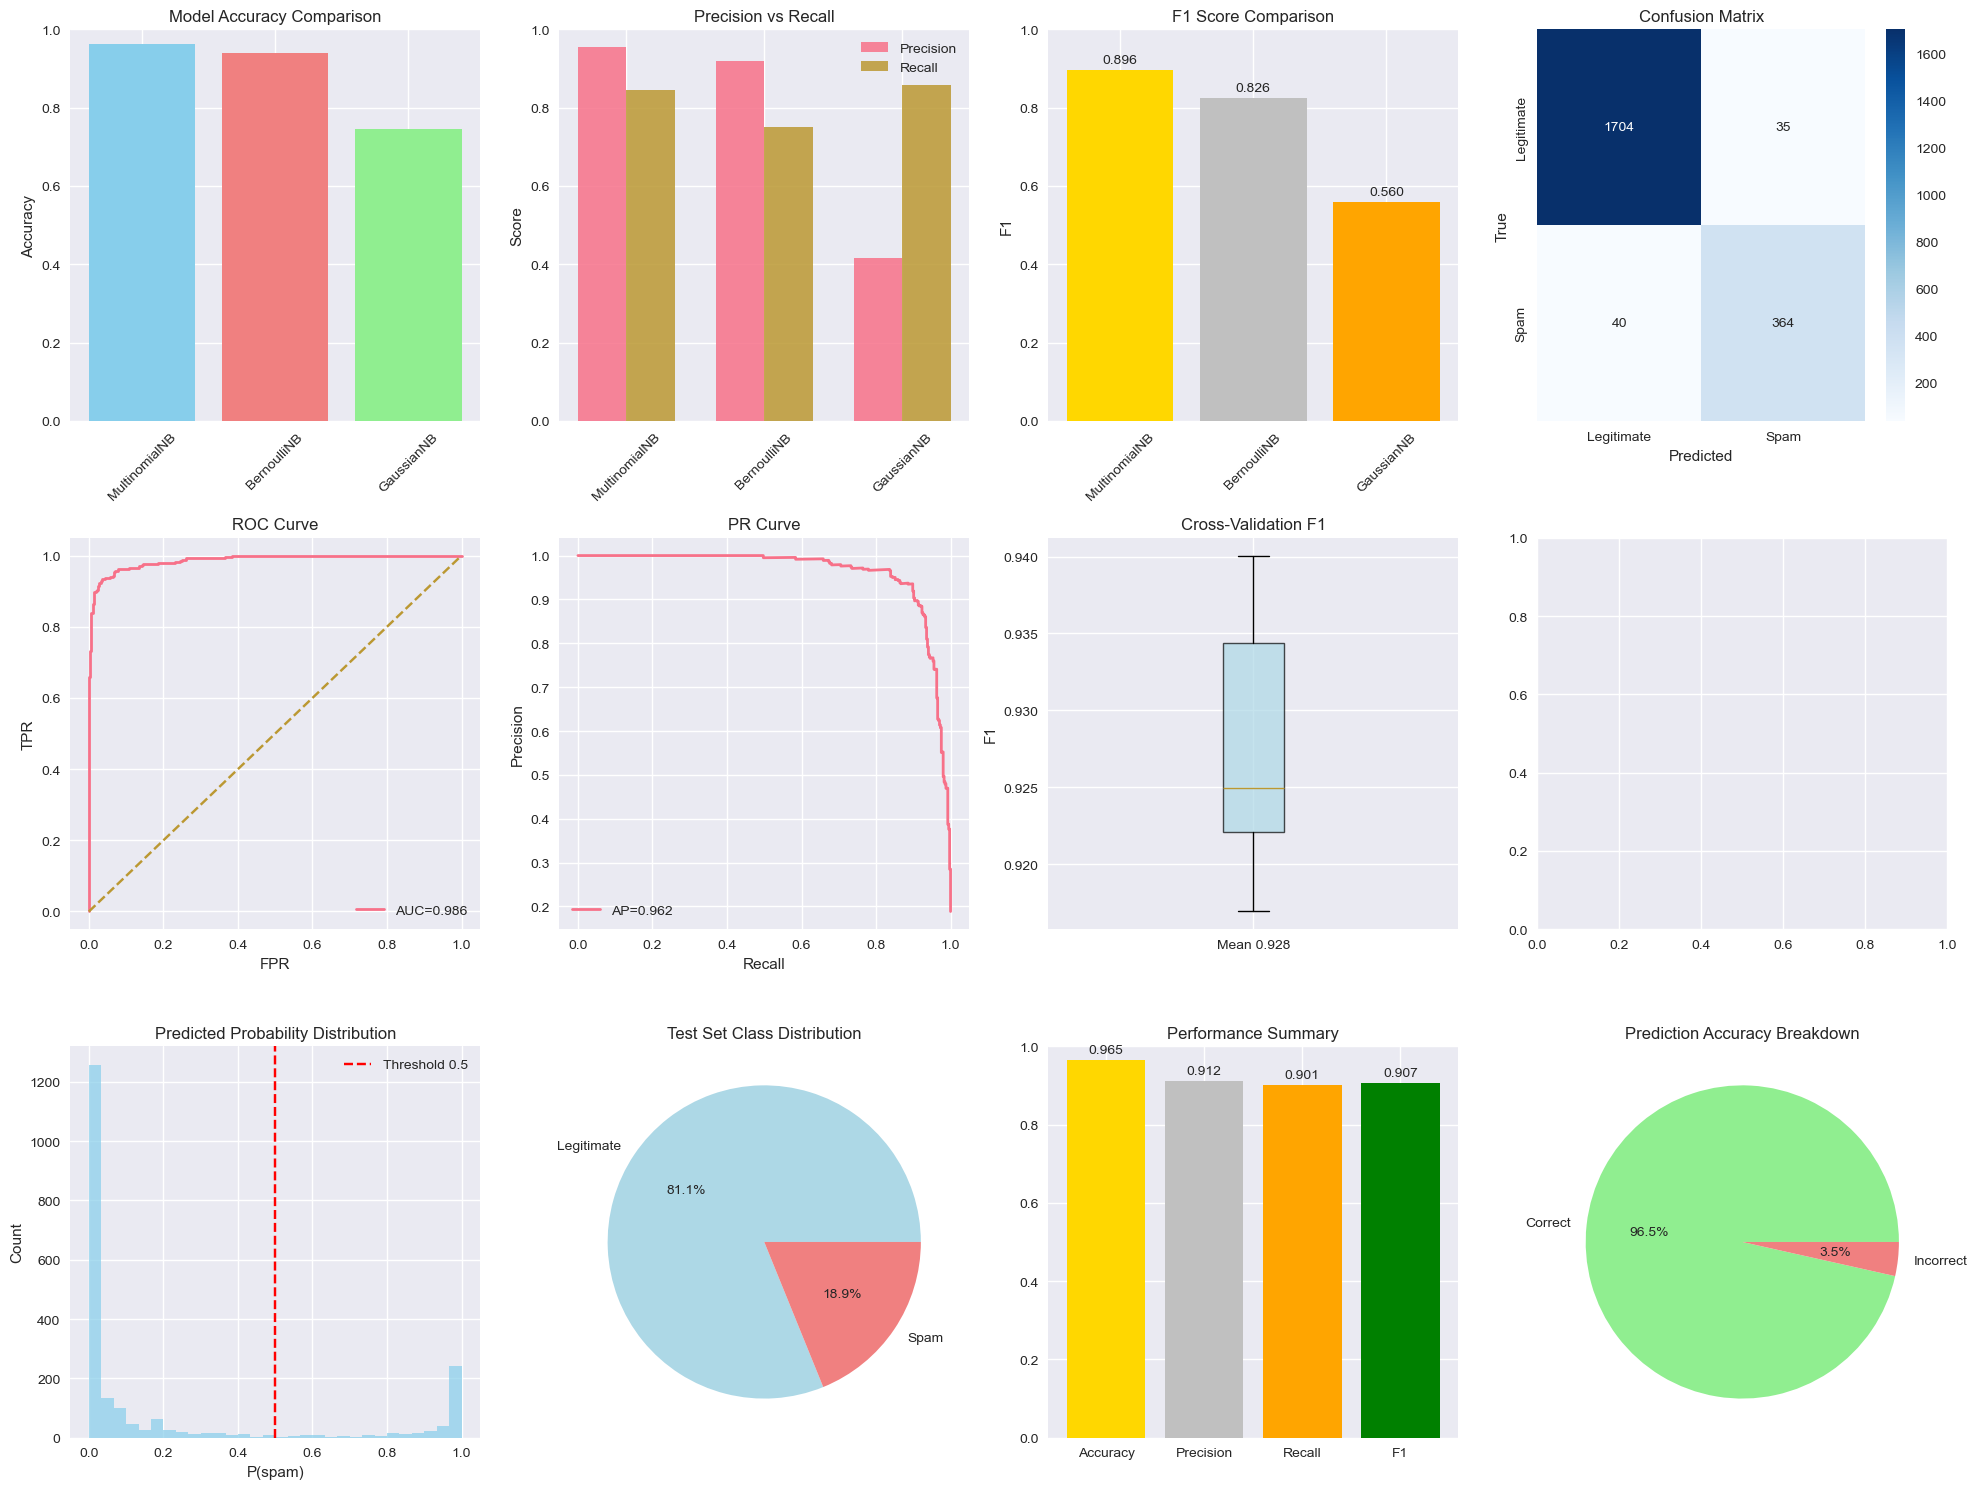

Visualizations saved to /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/nb_test/naive_bayes_evaluation.png

Saving results...
Results saved to /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/outputs/nb_test/

Pipeline completed.


In [2]:
# save as: /Users/datschef/Documents/GitHub/cos30049_spam_detection/Assignment_2/data_processing/naive_bayes_fixed.py
"""
Naive Bayes Classification for Spam Detection
=============================================

Implements a Naive Bayes classifier for spam detection using the processed email datasets.
Includes comprehensive evaluation metrics and visualizations.

Author: ShieldMail Project
Date: 2024
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline

# ---------- Styling ----------
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ---------- Universal path setup (NB -> outputs/nb_test) ----------
try:
    THIS_DIR = Path(__file__).parent
except NameError:
    THIS_DIR = Path.cwd()

def find_assignment_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if p.name == "Assignment_2":
            return p
    return start.parent

ASSIGNMENT_ROOT = find_assignment_root(THIS_DIR)
PROCESSED_DIR   = ASSIGNMENT_ROOT / "outputs" / "processed"
NB_OUT_DIR      = ASSIGNMENT_ROOT / "outputs" / "nb_test"
NB_OUT_DIR.mkdir(parents=True, exist_ok=True)



class SpamDetectionNaiveBayes:
    """
    A comprehensive Naive Bayes implementation for spam detection
    """
    def __init__(self):
        self.models = {
            'MultinomialNB': MultinomialNB(),
            'BernoulliNB': BernoulliNB(),
            'GaussianNB': GaussianNB()
        }
        self.best_model = None
        self.best_model_name = None
        self.vectorizer = None
        self.results = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, train_path: Path, test_path: Path):
        """Load and report on the training and testing datasets."""
        print("Loading datasets...")
        self.train_data = pd.read_csv(train_path)
        self.test_data  = pd.read_csv(test_path)
        print(f"Training data shape: {self.train_data.shape}")
        print(f"Testing  data shape: {self.test_data.shape}")
        print(f"Missing (train): {self.train_data.isnull().sum().sum()} | Missing (test): {self.test_data.isnull().sum().sum()}")
        print("\nClass distribution (train):")
        print(self.train_data['label'].value_counts())
        print(f"Spam ratio (train): {self.train_data['label'].mean():.3f}")
        return self.train_data, self.test_data

    def preprocess_data(self):
        """Vectorize text with TF-IDF; keep digits; unigrams+bigrams."""
        print("\nPreprocessing data...")
        all_text = pd.concat([self.train_data['text'], self.test_data['text']], ignore_index=True)

        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        all_features = self.vectorizer.fit_transform(all_text)

        n_train = len(self.train_data)
        self.X_train = all_features[:n_train]
        self.X_test  = all_features[n_train:]
        self.y_train = self.train_data['label'].astype(int).values
        self.y_test  = self.test_data['label'].astype(int).values

        print(f"Feature matrix — Train: {self.X_train.shape}, Test: {self.X_test.shape}")

    def train_models(self):
        """Train NB variants and collect metrics."""
        print("\nTraining Naive Bayes models...")
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            if name == 'GaussianNB':
                Xtr = self.X_train.toarray()
                Xte = self.X_test.toarray()
                model.fit(Xtr, self.y_train)
                y_pred  = model.predict(Xte)
                y_proba = model.predict_proba(Xte)[:, 1]
            else:
                model.fit(self.X_train, self.y_train)
                y_pred  = model.predict(self.X_test)
                y_proba = model.predict_proba(self.X_test)[:, 1]

            acc = accuracy_score(self.y_test, y_pred)
            pre = precision_score(self.y_test, y_pred, zero_division=0)
            rec = recall_score(self.y_test, y_pred, zero_division=0)
            f1  = f1_score(self.y_test, y_pred, zero_division=0)

            self.results[name] = {
                'model': model,
                'accuracy': acc,
                'precision': pre,
                'recall': rec,
                'f1': f1,
                'predictions': y_pred,
                'probabilities': y_proba
            }
            print(f"{name} — Acc: {acc:.4f}  Prec: {pre:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}")

        self.best_model_name = max(self.results.keys(), key=lambda k: self.results[k]['f1'])
        self.best_model = self.results[self.best_model_name]['model']
        print(f"\nBest model: {self.best_model_name} (F1={self.results[self.best_model_name]['f1']:.4f})")
        return self.results

    def hyperparameter_tuning(self):
        """Grid-search the best NB variant with a vectorizer in a pipeline."""
        print(f"\nHyperparameter tuning for {self.best_model_name}...")
        if self.best_model_name == 'MultinomialNB':
            param_grid = {
                'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
                'classifier__fit_prior': [True, False]
            }
        elif self.best_model_name == 'BernoulliNB':
            param_grid = {
                'classifier__alpha': [0.1, 0.5, 1.0, 2.0],
                'classifier__binarize': [0.0, 0.5, 1.0]
            }
        else:
            print("Skipping tuning for GaussianNB.")
            return None

        pipe = Pipeline([
            ('vectorizer', self.vectorizer),
            ('classifier', self.best_model)
        ])

        gs = GridSearchCV(
            pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
        )
        gs.fit(self.train_data['text'], self.y_train)
        print(f"Best params: {gs.best_params_}")
        print(f"Best CV F1: {gs.best_score_:.4f}")
        self.best_model = gs.best_estimator_
        return gs

    def evaluate_model(self):
        """Evaluate best model; return metrics and predictions."""
        print(f"\nEvaluating {self.best_model_name}...")
        if hasattr(self.best_model, 'steps'):  # Pipeline after tuning
            y_pred  = self.best_model.predict(self.test_data['text'])
            y_proba = self.best_model.predict_proba(self.test_data['text'])[:, 1]
        else:
            if self.best_model_name == 'GaussianNB':
                y_pred  = self.best_model.predict(self.X_test.toarray())
                y_proba = self.best_model.predict_proba(self.X_test.toarray())[:, 1]
            else:
                y_pred  = self.best_model.predict(self.X_test)
                y_proba = self.best_model.predict_proba(self.X_test)[:, 1]

        acc = accuracy_score(self.y_test, y_pred)
        pre = precision_score(self.y_test, y_pred, zero_division=0)
        rec = recall_score(self.y_test, y_pred, zero_division=0)
        f1  = f1_score(self.y_test, y_pred, zero_division=0)

        if hasattr(self.best_model, 'steps'):
            cv_scores = cross_val_score(self.best_model, self.train_data['text'], self.y_train, cv=5, scoring='f1')
        else:
            cv_scores = cross_val_score(self.best_model, self.X_train, self.y_train, cv=5, scoring='f1')

        print("\nFinal Performance")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {pre:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"CV F1 (mean±std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, target_names=['Legitimate', 'Spam'], digits=4))

        return {
            'accuracy': acc,
            'precision': pre,
            'recall': rec,
            'f1': f1,
            'cv_scores': cv_scores,
            'predictions': y_pred,
            'probabilities': y_proba
        }

    def create_visualizations(self, evaluation_results):
        """Create evaluation plots and save to outputs/model_select/."""
        print("\nCreating visualizations...")
        fig = plt.figure(figsize=(20, 15))

        # 1. Model Accuracy Comparison
        plt.subplot(3, 4, 1)
        model_names = list(self.results.keys())
        accuracies  = [self.results[n]['accuracy'] for n in model_names]
        plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Model Accuracy Comparison'); plt.ylabel('Accuracy'); plt.xticks(rotation=45); plt.ylim(0, 1.0)

        # 2. Precision vs Recall Comparison
        plt.subplot(3, 4, 2)
        precisions = [self.results[n]['precision'] for n in model_names]
        recalls    = [self.results[n]['recall'] for n in model_names]
        x = np.arange(len(model_names)); w = 0.35
        plt.bar(x - w/2, precisions, w, label='Precision', alpha=0.85)
        plt.bar(x + w/2, recalls,    w, label='Recall',    alpha=0.85)
        plt.title('Precision vs Recall'); plt.ylabel('Score'); plt.xticks(x, model_names, rotation=45); plt.legend(); plt.ylim(0, 1.0)

        # 3. F1 Score Comparison
        plt.subplot(3, 4, 3)
        f1s = [self.results[n]['f1'] for n in model_names]
        bars = plt.bar(model_names, f1s, color=['gold', 'silver', 'orange'])
        plt.title('F1 Score Comparison'); plt.ylabel('F1'); plt.xticks(rotation=45); plt.ylim(0, 1.0)
        for b, v in zip(bars, f1s):
            plt.text(b.get_x()+b.get_width()/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 4. Confusion Matrix
        plt.subplot(3, 4, 4)
        cm = confusion_matrix(self.y_test, evaluation_results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Legitimate','Spam'], yticklabels=['Legitimate','Spam'])
        plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted')

        # 5. ROC Curve
        plt.subplot(3, 4, 5)
        fpr, tpr, _ = roc_curve(self.y_test, evaluation_results['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'AUC={roc_auc:.3f}')
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

        # 6. Precision–Recall Curve
        plt.subplot(3, 4, 6)
        prec, rec, _ = precision_recall_curve(self.y_test, evaluation_results['probabilities'])
        ap = average_precision_score(self.y_test, evaluation_results['probabilities'])
        plt.plot(rec, prec, lw=2, label=f'AP={ap:.3f}')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend()

        # 7. Cross-validation F1 boxplot
        plt.subplot(3, 4, 7)
        cv = evaluation_results['cv_scores']
        plt.boxplot(cv, patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7))
        plt.title('Cross-Validation F1'); plt.ylabel('F1'); plt.xticks([1],[f'Mean {cv.mean():.3f}'])

        # 8. Feature "importance" (log prob diff) for NB
        plt.subplot(3, 4, 8)
        if hasattr(self.best_model, 'feature_log_prob_'):
            feat_names = self.vectorizer.get_feature_names_out()
            # For MultiNB/BernoulliNB: difference in log prob between spam and ham
            diff = self.best_model.feature_log_prob_[1] - self.best_model.feature_log_prob_[0]
            top_idx = np.argsort(diff)[-20:]
            plt.barh([feat_names[i] for i in top_idx], diff[top_idx])
            plt.title('Top 20 Features (log P(spam) - log P(ham))')
            plt.xlabel('Log-Prob Difference')

        # 9. Probability histogram
        plt.subplot(3, 4, 9)
        plt.hist(evaluation_results['probabilities'], bins=30, alpha=0.7, color='skyblue')
        plt.axvline(0.5, color='red', ls='--', label='Threshold 0.5')
        plt.title('Predicted Probability Distribution'); plt.xlabel('P(spam)'); plt.ylabel('Count'); plt.legend()

        # 10. Test class distribution
        plt.subplot(3, 4, 10)
        cls_counts = np.bincount(self.y_test)
        plt.pie(cls_counts, labels=['Legitimate','Spam'], autopct='%1.1f%%', colors=['lightblue','lightcoral'])
        plt.title('Test Set Class Distribution')

        # 11. Metrics summary bars
        plt.subplot(3, 4, 11)
        metrics = ['Accuracy','Precision','Recall','F1']
        vals = [evaluation_results['accuracy'], evaluation_results['precision'],
                evaluation_results['recall'], evaluation_results['f1']]
        bars = plt.bar(metrics, vals, color=['gold','silver','orange','green'])
        plt.title('Performance Summary'); plt.ylim(0,1)
        for b, v in zip(bars, vals):
            plt.text(b.get_x()+b.get_width()/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 12. Error pie
        plt.subplot(3, 4, 12)
        errors = (self.y_test != evaluation_results['predictions']).sum()
        correct = len(self.y_test) - errors
        plt.pie([correct, errors], labels=['Correct','Incorrect'], autopct='%1.1f%%', colors=['lightgreen','lightcoral'])
        plt.title('Prediction Accuracy Breakdown')

        out_png = NB_OUT_DIR / "naive_bayes_evaluation.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Visualizations saved to {out_png}")

    def save_results(self, evaluation_results):
        """Save metrics, predictions, and a summary under outputs/model_select/."""
        print("\nSaving results...")
        metrics_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'Accuracy':  [self.results[n]['accuracy']  for n in self.results],
            'Precision': [self.results[n]['precision'] for n in self.results],
            'Recall':    [self.results[n]['recall']    for n in self.results],
            'F1_Score':  [self.results[n]['f1']        for n in self.results],
        })
        metrics_df.to_csv(NB_OUT_DIR / "naive_bayes_metrics.csv", index=False)

        preds_df = pd.DataFrame({
            'true_label': self.y_test,
            'predicted_label': evaluation_results['predictions'],
            'predicted_probability': evaluation_results['probabilities']
        })
        preds_df.to_csv(NB_OUT_DIR / "naive_bayes_predictions.csv", index=False)

        with open(NB_OUT_DIR/ "naive_bayes_summary.txt", "w", encoding="utf-8") as f:
            f.write("NAIVE BAYES SPAM DETECTION — MODEL SUMMARY\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Best Model: {self.best_model_name}\n")
            f.write(f"Training Samples: {len(self.y_train)}\n")
            f.write(f"Testing  Samples: {len(self.y_test)}\n")
            f.write(f"Features: {self.X_train.shape[1]}\n\n")
            f.write("FINAL PERFORMANCE METRICS:\n")
            f.write(f"- Accuracy:  {evaluation_results['accuracy']:.4f}\n")
            f.write(f"- Precision: {evaluation_results['precision']:.4f}\n")
            f.write(f"- Recall:    {evaluation_results['recall']:.4f}\n")
            f.write(f"- F1 Score:  {evaluation_results['f1']:.4f}\n\n")
            f.write("CROSS-VALIDATION (F1):\n")
            f.write(f"- Mean: {evaluation_results['cv_scores'].mean():.4f}\n")
            f.write(f"- Std : {evaluation_results['cv_scores'].std():.4f}\n\n")
            f.write("MODEL COMPARISON (F1):\n")
            for name in self.results:
                f.write(f"- {name:12}: {self.results[name]['f1']:.4f}\n")

        print(f"Results saved to {NB_OUT_DIR}/")


def main():
    """Run the full Naive Bayes pipeline."""
    print("SHIELDMAIL — NAIVE BAYES SPAM DETECTION\n" + "=" * 60)
    nb = SpamDetectionNaiveBayes()

    train_path = PROCESSED_DIR / "emails_merged.train.csv"
    test_path  = PROCESSED_DIR / "emails_merged.test.csv"

    nb.load_data(train_path, test_path)
    nb.preprocess_data()
    nb.train_models()
    nb.hyperparameter_tuning()
    eval_res = nb.evaluate_model()
    nb.create_visualizations(eval_res)
    nb.save_results(eval_res)
    print("\nPipeline completed.\n" + "=" * 60)


if __name__ == "__main__":
    main()
